# Data preparation and exploration

We prepare the KLIFS dataset to be used for `kissim` encoding and comparison.

- Fetch all structures in KLIFS (metadata).
- Filter dataset by
  - Species
  - DFG conformation (optional)
  - Resolution
  - Quality score
  - Maximum number of mutations in the pocket
  - Maximum number of missing residues in the pocket (most will be caught by quality score already) 
  - Best struture per kinase-PDB pair
- Save the KLIFS structure IDs for the filtered dataset.

__Note__: The KLIFS data is prepared only on the basis of the structures' metadata from KLIFS. Additional filtering will happen during fingerprint generation, where the actual structural data (coordiantes ect.) are used.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import logging

import pandas as pd
from opencadd.databases.klifs import setup_remote, setup_local

from src.paths import PATH_DATA, PATH_DATA_KLIFS_DOWNLOAD, PATH_DATA_KLIFS_DOWNLOAD_TEST
from src.data.structures import filters, explorer

In [3]:
logging.basicConfig(level=logging.INFO)
pd.set_option("display.max_columns", 50)

In [4]:
SPECIES = "Human"
RESOLUTION_MAX = 3
QUALITYSCORE_MIN = 6
N_ALLOWED_MUTATIONS = 3
N_ALLOWED_MISSING_RESIDUES = 8

HERE = Path(_dh[-1])  # noqa: F821
DATA = PATH_DATA

## Fetch structures (metadata)

In [5]:
session = setup_remote()

INFO:opencadd.databases.klifs.api:Set up remote session...
INFO:opencadd.databases.klifs.api:Remote session is ready!


In [6]:
session.structures.by_structure_pdb_id("3poz")

,structure.klifs_id,structure.pdb_id,structure.alternate_model,structure.chain,species.klifs,kinase.klifs_id,kinase.klifs_name,kinase.names,kinase.family,kinase.group,structure.pocket,ligand.expo_id,ligand_allosteric.expo_id,ligand.klifs_id,ligand_allosteric.klifs_id,ligand.name,ligand_allosteric.name,structure.dfg,structure.ac_helix,structure.resolution,structure.qualityscore,structure.missing_residues,structure.missing_atoms,structure.rmsd1,structure.rmsd2,interaction.fingerprint,structure.front,structure.gate,structure.back,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v,structure.grich_distance,structure.grich_angle,structure.grich_rotation,structure.filepath,structure.curation_flag
0,7308,3poz,-,A,Human,406,EGFR,<NA>,<NA>,<NA>,KVLGSGAFGTVYKVAIKELEILDEAYVMASVDPHVCRLLGIQLITQ...,03P,-,2325,0,<NA>,<NA>,in,out,1.5,8.0,0,0,0.815,2.155,<NA>,True,True,True,False,False,True,True,True,True,False,False,False,False,False,False,16.7505,53.429001,31.0905,<NA>,False


In [7]:
PATH_DATA_KLIFS_DOWNLOAD

PosixPath('/home/dominique/Documents/GitHub/kissim_app/src/../data/external/structures/20210902_KLIFS_HUMAN')

In [8]:
try:
    klifs_session = setup_local(PATH_DATA_KLIFS_DOWNLOAD)
except FileNotFoundError:
    # Use this KLIFS dataset for CI
    klifs_session = setup_local(PATH_DATA_KLIFS_DOWNLOAD_TEST)

print(f"Number of structures: {len(klifs_session._database)}")

INFO:opencadd.databases.klifs.api:Set up local session...
INFO:opencadd.databases.klifs.local:Load overview.csv...
INFO:opencadd.databases.klifs.local:Load KLIFS_export.csv...
INFO:opencadd.databases.klifs.local:Merge both csv files...
INFO:opencadd.databases.klifs.local:Add paths to coordinate folders to structures...
INFO:opencadd.databases.klifs.local:Add KLIFS IDs to structures (uses remote since not available locally!)...
ERROR:opencadd.databases.klifs.local:Local structure is not part of SerializableSwaggerClient(https://dev.klifs.net/api_v2) (yet? any more?): 7ree-A-A
ERROR:opencadd.databases.klifs.local:Expected type to be dict for value [400, 'KLIFS error: An unknown ligand ID was provided'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.
ERROR:opencadd.databases.klifs.local:Local structure is not part of SerializableSwaggerClient(https://dev.klifs.net/api_v2) (yet? any more?): 7ree-B-A
ERROR:opencadd.databases.klifs.local:Expected type to be dict for value [

Number of structures: 11795


In [9]:
structures = klifs_session.structures.all_structures()
print(structures.shape)
structures.head()

(11795, 46)


,structure.klifs_id,structure.pdb_id,structure.alternate_model,structure.chain,species.klifs,kinase.klifs_id,kinase.klifs_name,kinase.names,kinase.family,kinase.group,structure.pocket,ligand.expo_id,ligand_allosteric.expo_id,ligand.klifs_id,ligand_allosteric.klifs_id,ligand.name,ligand_allosteric.name,structure.dfg,structure.ac_helix,structure.resolution,structure.qualityscore,structure.missing_residues,structure.missing_atoms,structure.rmsd1,structure.rmsd2,interaction.fingerprint,structure.front,structure.gate,structure.back,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v,structure.grich_distance,structure.grich_angle,structure.grich_rotation,structure.filepath,structure.curation_flag
0,1,3dko,A,A,Human,415,EphA7,"['EPHA7', 'EphA7']",Eph,TK,RVIGA_EFGEVCSVAIKTLDFLCEASIMGQFDPNVVHLEGVMIVIE...,IHZ,-,<NA>,<NA>,5-[(2-methyl-5-{[3-(trifluoromethyl)phenyl]car...,-,out,in,2.00,8.1,3,7,0.944,2.254,0000000000000010000000000000000000000000000000...,<NA>,<NA>,<NA>,False,False,True,True,False,False,False,True,False,True,False,False,NaN,NaN,NaN,HUMAN/EphA7/3dko_altA_chainA,<NA>
1,3,3dko,B,A,Human,415,EphA7,"['EPHA7', 'EphA7']",Eph,TK,RVIGA_EFGEVCSVAIKTLDFLCEASIMGQFDPNVVHLEGVMIVIE...,IHZ,-,<NA>,<NA>,5-[(2-methyl-5-{[3-(trifluoromethyl)phenyl]car...,-,out,in,2.00,8.1,3,7,0.944,2.254,0000000000000010000000000000000000000000000000...,<NA>,<NA>,<NA>,False,False,True,True,False,False,False,True,False,True,False,False,NaN,NaN,NaN,HUMAN/EphA7/3dko_altB_chainA,<NA>
2,5,3v8t,B,A,Human,474,ITK,['ITK'],Tec,TK,QEIGSG___LVHLVAIKTIDFIEEAEVMMKLSPKLVQLYGVCLVFE...,477,-,<NA>,<NA>,"3-{2-[5-(difluoromethyl)-2H-thieno[3,2-c]pyraz...",-,in,in,2.00,7.8,4,6,0.842,2.047,0000000000000010000000000000000000000000000000...,<NA>,<NA>,<NA>,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,HUMAN/ITK/3v8t_altB_chainA,<NA>
3,6,4kio,A,D,Human,474,ITK,['ITK'],Tec,TK,QEIGSGQFGLVHLVAIKTIDFIEEAEVMMKLSPKLVQLYGVCLVFE...,G6K,-,<NA>,<NA>,"1-[(3S)-3-{[4-(morpholin-4-ylmethyl)-6-([1,3]t...",-,in,in,2.18,8.6,1,10,0.842,2.151,0000000000000010000001000000000000000000000000...,<NA>,<NA>,<NA>,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,HUMAN/ITK/4kio_altA_chainD,<NA>
4,7,4kio,B,C,Human,474,ITK,['ITK'],Tec,TK,QEIGSGQFGLVHLVAIKTIDFIEEAEVMMKLSPKLVQLYGVCLVFE...,G5K,-,<NA>,<NA>,"1-[(3S)-3-{[4-(morpholin-4-ylmethyl)-6-([1,3]t...",-,in,in,2.18,9.0,0,10,0.840,2.148,0000000000000010001001000000000000000000000000...,<NA>,<NA>,<NA>,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,HUMAN/ITK/4kio_altB_chainC,<NA>


In [10]:
klifs_session = setup_remote()

kinases_short = klifs_session.kinases.all_kinases()
kinases = klifs_session.kinases.by_kinase_klifs_id(kinases_short["kinase.klifs_id"].to_list())
structures = pd.merge(structures, kinases[["kinase.klifs_id", "kinase.pocket"]])

INFO:opencadd.databases.klifs.api:Set up remote session...
INFO:opencadd.databases.klifs.api:Remote session is ready!


## Explore structures in full dataset

### Species, DFG/aC-helix conformations, ligand

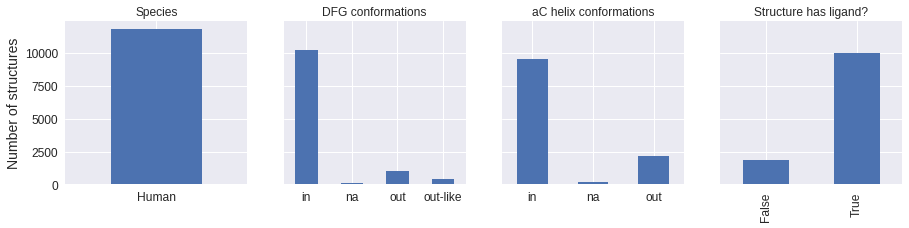

In [11]:
explorer.plot_important_categories(structures);

### Resolution vs. quality score

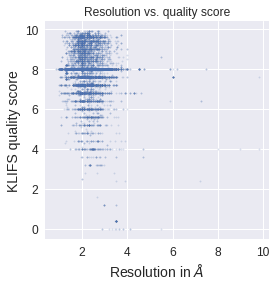

In [12]:
explorer.plot_resolution_vs_qualityscore(structures);

### Number of structures per kinase-PDB pair

How many kinase-PDB pairs are represented by how many structures?

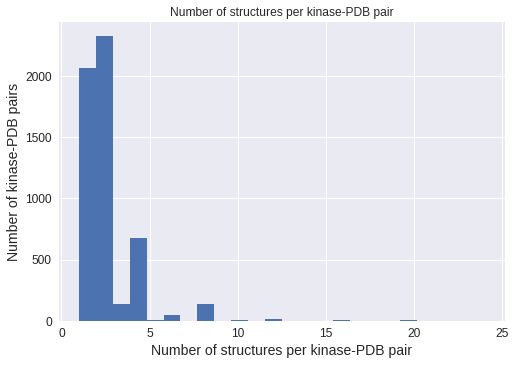

In [13]:
explorer.plot_number_of_structures_per_kinase_pdb_pair(structures);

## Filter and save structures

In [14]:
n_structures = {}
n_kinases = {}

### DFG-all

In [15]:
%%time

structures_filtered = (
    structures.pipe(filters.make_copy)
    .pipe(filters.select_species, SPECIES)
    .pipe(filters.select_unflagged_structures_only)
    # .pipe(filters.select_dfg, DFG_CONFORMATION)
    .pipe(filters.select_resolution, RESOLUTION_MAX)
    .pipe(filters.select_qualityscore, QUALITYSCORE_MIN)
    .pipe(filters.select_maximum_n_mutations, N_ALLOWED_MUTATIONS)
    .pipe(filters.select_maximum_n_missing_residues, N_ALLOWED_MISSING_RESIDUES)
    .pipe(filters.select_best_pdb_kinase_pairs)
)

structures_filtered.reset_index(inplace=True, drop=True)
structures_filtered["structure.klifs_id"].sort_values().to_csv(
    DATA / "processed/structure_klifs_ids_all.txt", index=None, header=None
)

n_structures["all"] = len(structures_filtered)
n_kinases["all"] = len(structures_filtered["kinase.klifs_name"].drop_duplicates())

INFO:src.data.structures.filters:make_copy                       11795 structures (-1 day, 23:59:59.995327s)
INFO:src.data.structures.filters:select_species                  11795 structures (-1 day, 23:59:59.992748s)
INFO:src.data.structures.filters:select_unflagged_structures_only  11639 structures (-1 day, 23:59:56.669264s)
INFO:src.data.structures.filters:select_resolution               10683 structures (-1 day, 23:59:59.993346s)
INFO:src.data.structures.filters:select_qualityscore             10230 structures (-1 day, 23:59:59.993548s)
INFO:src.data.structures.filters:select_maximum_n_mutations      10149 structures (-1 day, 23:59:15.709601s)
INFO:src.data.structures.filters:select_maximum_n_missing_residues  10144 structures (-1 day, 23:59:59.990068s)
INFO:src.data.structures.filters:select_best_pdb_kinase_pairs     4685 structures (-1 day, 23:59:59.976922s)


CPU times: user 45 s, sys: 108 ms, total: 45.1 s
Wall time: 47.7 s


In [16]:
# Get number of selected structures that are not the first model
structures_alt_not_a = structures_filtered[~structures_filtered["structure.alternate_model"].isin(["A", "-", "1"])]
print(structures_alt_not_a.shape)

(11, 47)


In [17]:
structures_alt_not_a

,structure.klifs_id,structure.pdb_id,structure.alternate_model,structure.chain,species.klifs,kinase.klifs_id,kinase.klifs_name,kinase.names,kinase.family,kinase.group,structure.pocket,ligand.expo_id,ligand_allosteric.expo_id,ligand.klifs_id,ligand_allosteric.klifs_id,ligand.name,ligand_allosteric.name,structure.dfg,structure.ac_helix,structure.resolution,structure.qualityscore,structure.missing_residues,structure.missing_atoms,structure.rmsd1,structure.rmsd2,interaction.fingerprint,structure.front,structure.gate,structure.back,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v,structure.grich_distance,structure.grich_angle,structure.grich_rotation,structure.filepath,structure.curation_flag,kinase.pocket
353,11133,6r4b,B,A,Human,259,AurA,"['AURKA', 'AurA']",Aur,Other,RPLGKGKFGNVYLLALKVLQLRREVEIQSHLRPNILRLYGYYLILE...,ADP,JSN,<NA>,<NA>,ADENOSINE-5'-DIPHOSPHATE,"(6~{S})-6-[2,4-bis(fluoranyl)phenyl]-~{N},~{N}...",in,in,2.15,8.6,0,14,0.778,2.096,0000000000000010000001000000100000010000000000...,<NA>,<NA>,<NA>,False,True,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,HUMAN/AurA/6r4b_altB_chainA,<NA>,RPLGKGKFGNVYLLALKVLQLRREVEIQSHLRPNILRLYGYYLILE...
475,6383,5fbn,B,D,Human,473,BTK,['BTK'],Tec,TK,KELGTGQFGVVKYVAIKMIEFIEEAKVMMNLSEKLVQLYGVFIITE...,5WF,T20,<NA>,<NA>,4-[8-azanyl-3-[(3~{R})-1-(3-methyloxetan-3-yl)...,3-nitro-N-[1-phenyl-5-(piperidin-1-ylmethyl)-1...,in,out,1.80,9.2,0,8,0.809,2.164,0000000000000010000001000000100000010000000000...,<NA>,<NA>,<NA>,False,False,False,True,True,False,True,False,False,False,False,False,NaN,NaN,NaN,HUMAN/BTK/5fbn_altB_chainD,<NA>,KELGTGQFGVVKYVAIKMIEFIEEAKVMMNLSEKLVQLYGVFIITE...
699,4099,2uzb,C,A,Human,198,CDK2,['CDK2'],CDK,CMGC,EKIGEGTYGVVYKVALKKITAIREISLLKELNPNIVKLLDVYLVFE...,C75,-,<NA>,<NA>,"4-{5-[(Z)-(2-IMINO-4-OXO-1,3-THIAZOLIDIN-5-YLI...",-,in,in,2.70,8.0,0,0,0.776,2.086,0000000000000010000000000000000000000000000000...,<NA>,<NA>,<NA>,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,HUMAN/CDK2/2uzb_altC_chainA,<NA>,EKIGEGTYGVVYKVALKKITAIREISLLKELNPNIVKLLDVYLVFE...
949,11200,6q4a,B,A,Human,198,CDK2,['CDK2'],CDK,CMGC,EKIGEGTYGVVYKVALKKITAIREISLLKELNPNIVKLLDVYLVFE...,HGW,-,<NA>,<NA>,5-iodanylpyrimidine,-,in,out,1.13,8.0,0,0,0.852,2.187,0000000000000010000000000000000000000000000000...,<NA>,<NA>,<NA>,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,HUMAN/CDK2/6q4a_altB_chainA,<NA>,EKIGEGTYGVVYKVALKKITAIREISLLKELNPNIVKLLDVYLVFE...
954,11211,6q4f,B,A,Human,198,CDK2,['CDK2'],CDK,CMGC,EKIGEGTYGVVYKVALKKITAIREISLLKELNPNIVKLLDVYLVFE...,26D,-,<NA>,<NA>,"PYRIDINE-2,6-DIAMINE",-,in,out,1.21,9.6,0,4,0.849,2.190,0000000000000010000000000000000000000000000000...,<NA>,<NA>,<NA>,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,HUMAN/CDK2/6q4f_altB_chainA,<NA>,EKIGEGTYGVVYKVALKKITAIREISLLKELNPNIVKLLDVYLVFE...
959,11186,6q4k,B,A,Human,198,CDK2,['CDK2'],CDK,CMGC,EKIGEGTYGVVYKVALKKITAIREISLLKELNPNIVKLLDVYLVFE...,-,HHW,<NA>,<NA>,-,(~{E})-3-[3-[(4-chlorophenyl)carbamoyl]phenyl]...,in,out,1.06,8.0,0,0,0.847,2.188,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,HUMAN/CDK2/6q4k_altB_chainA,<NA>,EKIGEGTYGVVYKVALKKITAIREISLLKELNPNIVKLLDVYLVFE...
2171,216,4i4e,B,A,Human,425,FAK,"['PTK2', 'FAK']",FAK,TK,RCIGEGQFGDVHQVAIKTCKFLQEALTMRQFDPHIVKLIGVWIIME...,1BQ,-,<NA>,<NA>,[4-(2-hydroxyethyl)piperidin-1-yl][4-(5-methyl...,-,in,in,1.55,6.8,3,0,0.796,2.131,0000000000000010000000000000000000000000000000...,<NA>,<NA>,<NA>,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,HUMAN/FAK/4i4e_altB_chainA,<NA>,RCIGEGQFGDVHQVAIKTCKFLQEALTMRQFDPHIVKLIGVWIIME...
2215,3496,4v04,B,B,Human,428,FGFR1,['FGFR1'],FGFR,TK,KPLGEGAFGQVVLVAVKMLDLISEMEMMKMIGKNIINLLGAYVIVE...,-,-,<NA>,<NA>,-,-

### DFG-in / DFG-out

In [18]:
%%time

for dfg_conformation in ["in", "out"]:
    structures_filtered = (
        structures.pipe(filters.make_copy)
        .pipe(filters.select_species, SPECIES)
        .pipe(filters.select_unflagged_structures_only)
        .pipe(filters.select_resolution, RESOLUTION_MAX)
        .pipe(filters.select_qualityscore, QUALITYSCORE_MIN)
        .pipe(filters.select_maximum_n_mutations, N_ALLOWED_MUTATIONS)
        .pipe(filters.select_maximum_n_missing_residues, N_ALLOWED_MISSING_RESIDUES)
        .pipe(filters.select_dfg, dfg_conformation)
        .pipe(filters.select_best_pdb_kinase_pairs)
    )
    structures_filtered.reset_index(inplace=True, drop=True)
    structures_filtered["structure.klifs_id"].sort_values().to_csv(
        DATA / f"processed/structure_klifs_ids_dfg_{dfg_conformation}.txt", index=None, header=None
    )
    n_structures[f"dfg_{dfg_conformation}"] = len(structures_filtered)
    n_kinases[f"dfg_{dfg_conformation}"] = len(
        structures_filtered["kinase.klifs_name"].drop_duplicates()
    )

INFO:src.data.structures.filters:make_copy                       11795 structures (-1 day, 23:59:59.995307s)
INFO:src.data.structures.filters:select_species                  11795 structures (-1 day, 23:59:59.992721s)
INFO:src.data.structures.filters:select_unflagged_structures_only  11639 structures (-1 day, 23:59:56.698213s)
INFO:src.data.structures.filters:select_resolution               10683 structures (-1 day, 23:59:59.993446s)
INFO:src.data.structures.filters:select_qualityscore             10230 structures (-1 day, 23:59:59.993687s)
INFO:src.data.structures.filters:select_maximum_n_mutations      10149 structures (-1 day, 23:59:16.305992s)
INFO:src.data.structures.filters:select_maximum_n_missing_residues  10144 structures (-1 day, 23:59:59.990460s)
INFO:src.data.structures.filters:select_dfg                       8976 structures (-1 day, 23:59:59.994157s)
INFO:src.data.structures.filters:select_best_pdb_kinase_pairs     4115 structures (-1 day, 23:59:59.979897s)
INFO:src.data.

CPU times: user 1min 29s, sys: 199 ms, total: 1min 29s
Wall time: 1min 34s


## Dataset statistics

In [19]:
n_structures = pd.Series(n_structures)
n_structures.name = "n_structures"
n_kinases = pd.Series(n_kinases)
n_kinases.name = "n_kinases"
pd.concat([n_structures, n_kinases], axis=1).transpose()

,all,dfg_in,dfg_out
n_structures,4685,4115,407
n_kinases,278,256,71
